# Project: Identify Customer Segments

In this project, you will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that you will use has been provided by our partners at Bertelsmann Arvato Analytics, and represents a real-life data science task.

This notebook will help you complete this task by providing a framework within which you will perform your analysis steps. In each step of the project, you will see some text describing the subtask that you will perform, followed by one or more code cells for you to complete your work. **Feel free to add additional code and markdown cells as you go along so that you can explore everything in precise chunks.** The code cells provided in the base template will outline only the major tasks, and will usually not be enough to cover all of the minor tasks that comprise it.

It should be noted that while there will be precise guidelines on how you should handle certain tasks in the project, there will also be places where an exact specification is not provided. **There will be times in the project where you will need to make and justify your own decisions on how to treat the data.** These are places where there may not be only one way to handle the data. In real-life tasks, there may be many valid ways to approach an analysis task. One of the most important things you can do is clearly document your approach so that other scientists can understand the decisions you've made.

At the end of most sections, there will be a Markdown cell labeled **Discussion**. In these cells, you will report your findings for the completed section, as well as document the decisions that you made in your approach to each subtask. **Your project will be evaluated not just on the code used to complete the tasks outlined, but also your communication about your observations and conclusions at each stage.**

In [281]:
# import libraries here; add more as necessary
from sklearn.preprocessing import OneHotEncoder
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import ast
from Functions import ColDistsHist, NaNValuesDistribution, Subsets, PCAvariance, PCATest
from bs4 import BeautifulSoup
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
# magic word for producing visualizations in notebook
%matplotlib inline

### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. You will use this information to cluster the general population into groups with similar demographic properties. Then, you will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so you'll need an additional argument in your [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that you take a little bit of time just browsing the general structure of the dataset and feature summary file. You'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help you get your bearings.

In [282]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';')

In [283]:
# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias_copy = azdias.copy()
feat_info_copy = feat_info.copy()
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


> **Tip**: Add additional cells to keep everything in reasonably-sized chunks! Keyboard shortcut `esc --> a` (press escape to enter command mode, then press the 'A' key) adds a new cell before the active cell, and `esc --> b` adds a new cell after the active cell. If you need to convert an active cell to a markdown cell, use `esc --> m` and to convert to a code cell, use `esc --> y`. 

## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. You will use this file to help you make cleaning decisions during this stage of the project. First of all, you should assess the demographics data in terms of missing data. Pay attention to the following points as you perform your analysis, and take notes on what you observe. Make sure that you fill in the **Discussion** cell with your findings and decisions at the end of each step that has one!



#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. You'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. You might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

**As one more reminder, you are encouraged to add additional cells to break up your analysis into manageable chunks.**

First, the format of codes related with the missing values in the feat_info dataframe need to be changed. For that, the brackets of the codes and the empty codes are dropped because they are not used. Then, a dictionary is created with codes related with each specific column found in the attribute’s column of the feat_info dataframe for its later use.

In [284]:
#Removing brackets in the missing values column for their processing
feat_info.missing_or_unknown = feat_info.missing_or_unknown.str.replace('[','').str.replace(']','')

#Removing empty missing values codes
feat_info.drop(feat_info[feat_info['missing_or_unknown'] == ''].index, inplace=True)

#Creating a dictionary for processing the missing values codes
Dict = {}

for i, attribute in zip(feat_info.index,feat_info.attribute):
    Dict[attribute] = feat_info.missing_or_unknown.loc[i].split(',')

In the following code section are replaced codes related with missing or unknown values in azdias dataframe with *nan* values, accordingly with the created dictionary *Dict*. Additionally, the amount of natural missing values and missing values related with the codes are quantified.

In [285]:
#Finding columns with natural missing values in the azdias dataframe
null_columns=azdias.columns[azdias.isnull().any()]

#Finding the amount of natural missing values and the missing values related with the missing codes
NatNaN = azdias.isnull().sum().values
CodNaN = np.zeros(shape=azdias.shape[1])

#Changing missing values codes with nan values
for key in list(Dict.keys()):
    
    for n in Dict[key]: 
        if azdias[key].dtype == 'O':
            suma = azdias[key][azdias[key] == n].value_counts().sum()
            CodNaN[feat_info[feat_info['attribute'] ==key].index] += suma
            azdias[key] = azdias[key].replace(n,np.nan)
        else:
            suma = azdias[key][azdias[key] == int(n)].value_counts().sum()
            CodNaN[feat_info[feat_info['attribute'] ==key].index] += suma
            azdias[key] = azdias[key].replace(int(n),np.nan)


Displaying the amount of natural missing values, the converted codes to missing values and the total number of missing values for the adias dataframe.

In [286]:
d = {'NaturalNaN':NatNaN , 'ConvNaN':CodNaN, 'TotalNaN':NatNaN+CodNaN}
dfTest = pd.DataFrame(d)
dfTest.sum()

NaturalNaN    4896838.0
ConvNaN       3477091.0
TotalNaN      8373929.0
dtype: float64

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. You will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns. Identify and document these columns. While some of these columns might have justifications for keeping or re-encoding the data, for this project you should just remove them from the dataframe. (Feel free to make remarks about these outlier columns in the discussion, however!)

For the remaining features, are there any patterns in which columns have, or share, missing data?

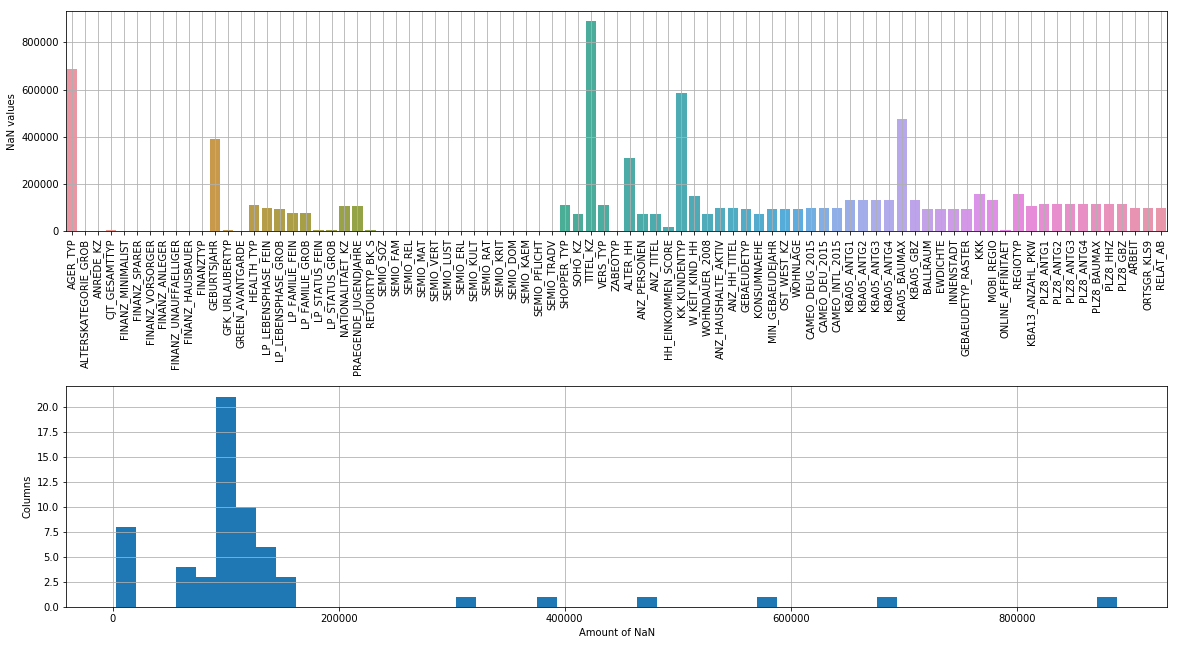

In [287]:
# Perform an assessment of how much missing data there is in each column of the dataset.
null_columns=azdias.columns[azdias.isnull().any()]

# Displaying the amount og missing values on each column and the nan values distribution
NaNValuesDistribution(azdias, null_columns)


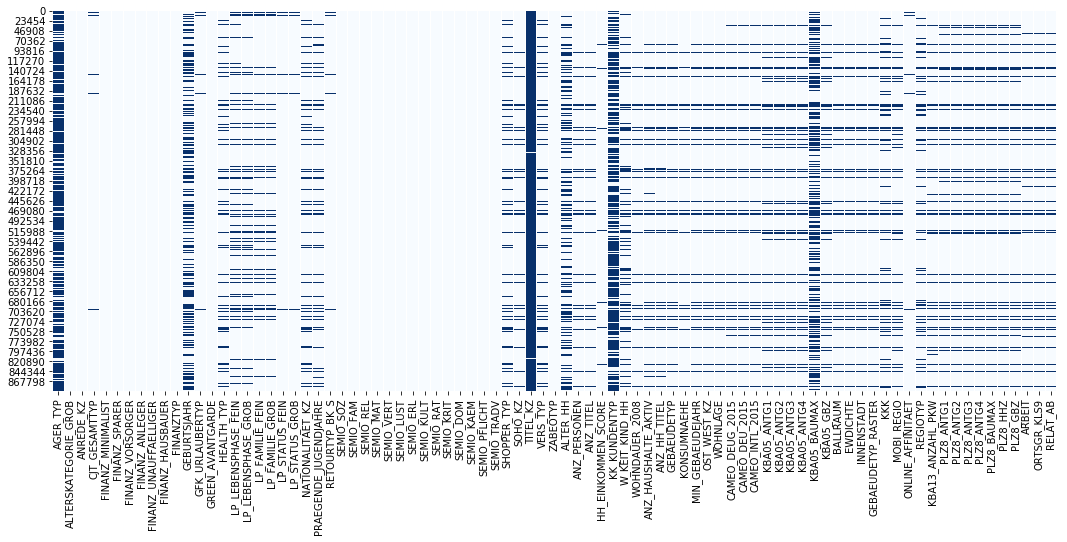

In [288]:
#Investigate patterns in the amount of missing values in the dataframe columns
fig, ax = plt.subplots(figsize=(18,7))  
sns.heatmap(azdias.isnull(), cbar=False,cmap="Blues");

In the previous figures can be observed that the behaviour of missing data is similar for some of the dataframe columns. The similarities varies among columns, being the strongest observable relation between TITEL_KZ and AGER_TYPE columns. This can also be observed when analyzing the distribution of the missing values, which looks like a normal distribution with many outliers, outliers that will be removed in the next section code:

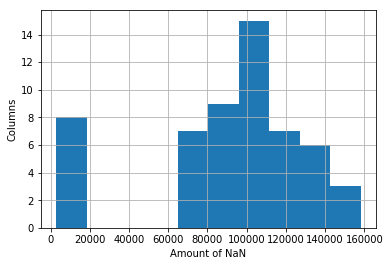

In [289]:
# Remove the outlier columns from the dataset. (You'll perform other data
# engineering tasks such as re-encoding and imputation later.)
A = azdias.isnull().sum()
q1 = A.quantile(0.25)
q3 = A.quantile(0.75)
IQran = q3-q1
In_fence  = q1-1.5*IQran
Out_fence = q3+1.5*IQran
columns = azdias[null_columns].columns[(azdias[null_columns].isnull().sum() < Out_fence)]
cols = [col for col in columns]
azdias = azdias[cols]
azdias.isnull().sum().hist();
plt.ylabel('Columns');
plt.xlabel('Amount of NaN');

In [290]:
#Creating a list to store names of modified columns
Steps = []
Steps.append(cols)

#### Discussion 1.1.2: Assess Missing Data in Each Column

The amount of missing data found were high in many columns, to the point that the *TITEL_KZ* column was composed mostly by missing values. There were clearly observable outliers presented in the dataframe, in terms of the amount of missing values that composed each of the columns. Furthermore, there were relationships among columns in terms of the amount of missing data which were also observable as patterns, as presented in previous figures. As result, the following columns were dropped:



In [291]:
#Dropped columns
for column in null_columns:
    if column not in cols:
        print(column)

AGER_TYP
GEBURTSJAHR
TITEL_KZ
ALTER_HH
KK_KUNDENTYP
KBA05_BAUMAX


#### Step 1.1.3: Assess Missing Data in Each Row

Now, you'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, you should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups. Select at least five of these columns and compare the distribution of values.
- You can use seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) function to create a bar chart of code frequencies and matplotlib's [`subplot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.subplot.html) function to put bar charts for the two subplots side by side.
- To reduce repeated code, you might want to write a function that can perform this comparison, taking as one of its arguments a column to be compared.

Depending on what you observe in your comparison, this will have implications on how you approach your conclusions later in the analysis. If the distributions of non-missing features look similar between the data with many missing values and the data with few or no missing values, then we could argue that simply dropping those points from the analysis won't present a major issue. On the other hand, if the data with many missing values looks very different from the data with few or no missing values, then we should make a note on those data as special. We'll revisit these data later on. **Either way, you should continue your analysis for now using just the subset of the data with few or no missing values.**

The first thing to consider is the amount of missing data present on each of the dataframe rows, given that the amount of missing values in the dataframe columns was already assessed. Then, the amount of remaining missing values after the previous section is:

In [292]:
# How much data is missing in each row of the dataset?
NullRows = azdias.isnull().any(1) == True
values = [n for n in azdias.loc[NullRows].isnull().sum(1).unique()]

print('Amount ot remaining missing values: ', azdias.loc[NullRows].shape[0])
print('Maximum number of missing values present in the dataframe rows: %1d' % (np.max(values)))


Amount ot remaining missing values:  268012
Maximum number of missing values present in the dataframe rows: 49


A better representation of the missing values among rows of the azdias dataframe can be observed by plotting the their distribution :

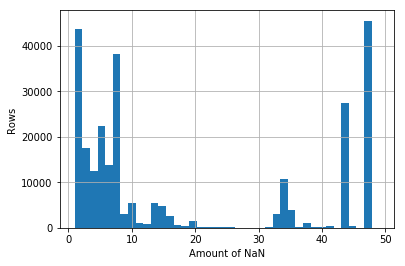

In [293]:
azdias.loc[NullRows].isnull().sum(1).hist(bins=40);
plt.ylabel('Rows');
plt.xlabel('Amount of NaN');

As required, the azdias datarame is divided into two dataframes, each of the them composed by different amount of missing values among their rows, as follow:

In [294]:
# Write code to divide the data into two subsets based on the number of missing
# values in each row.
NullRowsA = azdias[(azdias.isnull().sum(1) <= 20)].index
NullRowsB = azdias[(azdias.isnull().sum(1) > 20)].index

azdiasA = azdias.loc[NullRowsA]
azdiasB = azdias.loc[NullRowsB]

Steps.append(NullRowsA)

The amount of missing values In each of the columns of the generated subsets are presented next:

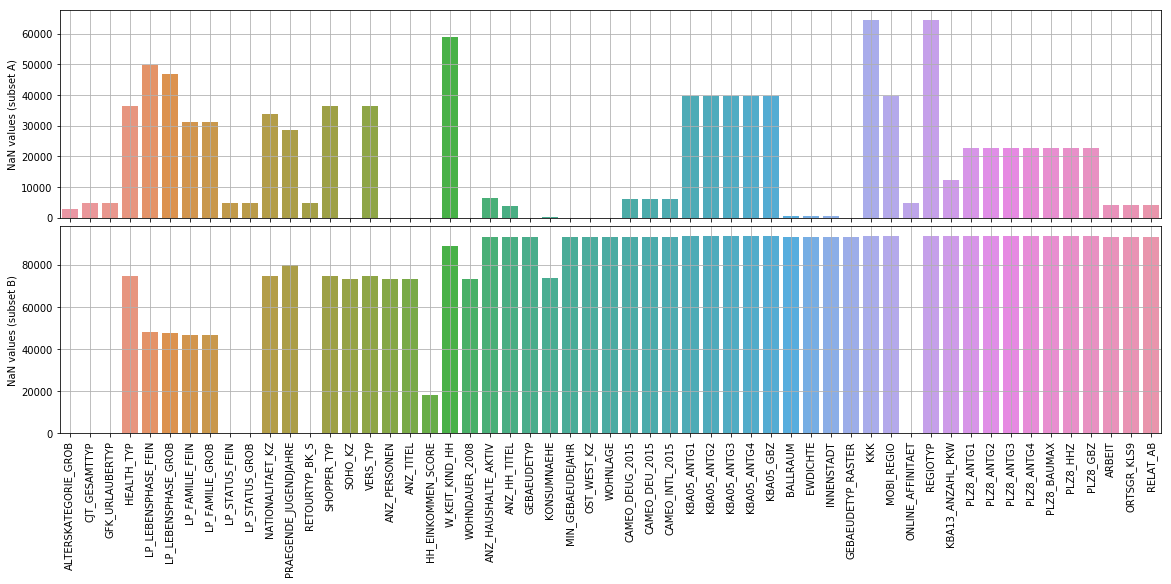

In [295]:
#Creating a dataframe with the amount of undefined values on each column for each ofm the azdias dataframe subsets
null_columns=azdias.columns[azdias.isnull().any()]

Subsets(azdiasA, azdiasB)

The generated subsets are compared by the distributions of their column’s values, for at least five of them. The *NaN* values were considered to see their effect on the doistributions, replacing them with *-1* values, for the plotting of the data.

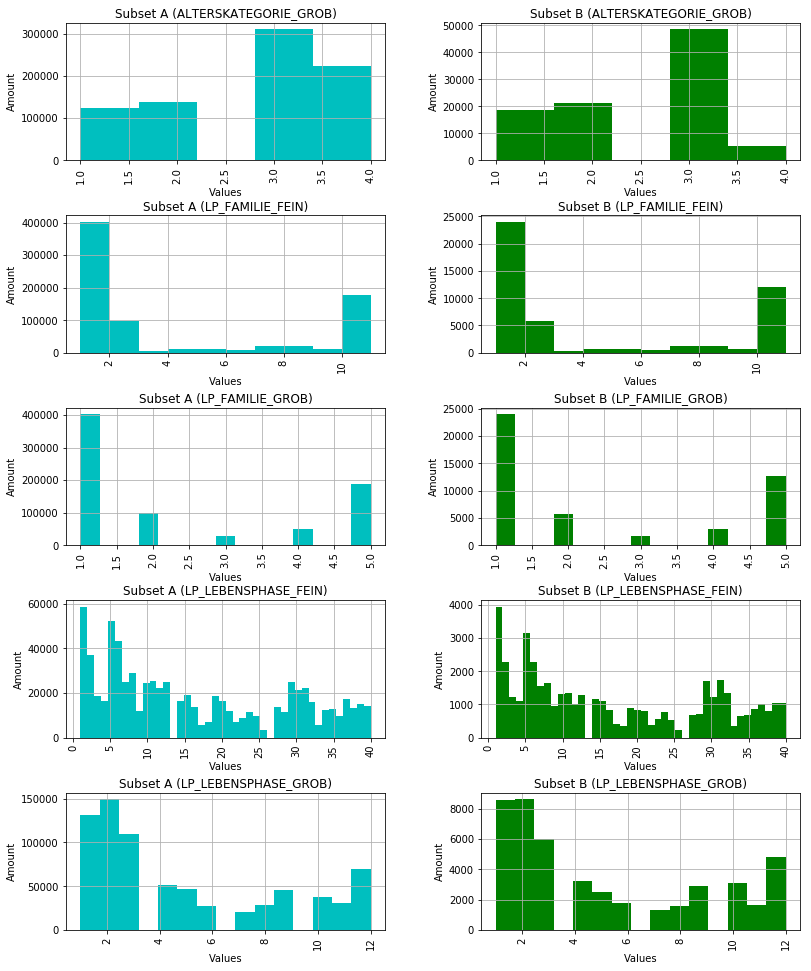

In [311]:
# Compare the distribution of values for at least five columns where there are
# no or few missing values, between the two subsets.
columnas = ['ALTERSKATEGORIE_GROB', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_LEBENSPHASE_FEIN', 'LP_LEBENSPHASE_GROB']
indices = np.random.randint(0,azdias.columns.shape[0], size=5)

bins=[5, 10, 15, 42, 15]
ColDistsHist(azdiasA,azdiasB,columnas, bins)

In [258]:
azdias.head()

,ALTERSKATEGORIE_GROB,CJT_GESAMTTYP,GFK_URLAUBERTYP,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2.0,2.0,10.0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,5.0,10.0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,3.0,3.0,10.0,3.0,3.0,1.0,1.0,1.0,3.0,2.0,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,4.0,2.0,1.0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,3.0,5.0,5.0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


#### Discussion 1.1.3: Assess Missing Data in Each Row

The effects of missing or unknown values in the azdias dataframe rows were less severe than their effects of the dataframe columns. Nonetheless, there exists a considerable amount of nan values in the rows of the dataframe. However, it was observed an improvement in the dataframe distributions once it was divided into two sets, each of them containing different amount of nan values in their rows. The set with less *nan* values showed a better distribution of values of interest, as was less affected by the presence of *nan* values, as expected.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which you can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, you need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.
- For numeric and interval data, these features can be kept without changes.
- Most of the variables in the dataset are ordinal in nature. While ordinal values may technically be non-linear in spacing, make the simplifying assumption that the ordinal variables can be treated as being interval in nature (that is, kept without any changes).
- Special handling may be necessary for the remaining two variable types: categorical, and 'mixed'.

In the first two parts of this sub-step, you will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether you will keep, drop, or re-encode each. Then, in the last part, you will create a new data frame with only the selected and engineered columns.

Data wrangling is often the trickiest part of the data analysis process, and there's a lot of it to be done here. But stick with it: once you're done with this step, you'll be ready to get to the machine learning parts of the project!

In [259]:
# How many features are there of each data type? 
feat_info.type.value_counts()

ordinal        45
categorical    19
mixed           7
numeric         3
interval        1
Name: type, dtype: int64

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, you would ordinarily need to encode the levels as dummy variables. Depending on the number of categories, perform one of the following:
- For binary (two-level) categoricals that take numeric values, you can keep them without needing to do anything.
- There is one binary variable that takes on non-numeric values. For this one, you need to re-encode the values as numbers or create a dummy variable.
- For multi-level categoricals (three or more values), you can choose to encode the values using multiple dummy variables (e.g. via [OneHotEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html)), or (to keep things straightforward) just drop them from the analysis. As always, document your choices in the Discussion section.

In order to re-encode the provided data, it was necessary to use of the provided *Data Dictionary* file, file that was converted to *html* format in order to create a python dictionary to use the contained information. The dictionary is created as follow:

In [260]:
#Creating a Dictionary with the file provided

with open('Data_Dictionary2.html') as file:
    soup = BeautifulSoup(file,'lxml')

DictAttr = {}

for Topic, Vars in zip(soup.find_all('h3'),soup.find_all('p')):
    DictAttr[Topic.contents[0][Topic.contents[0].find(' ')+1:]] = {}
    
    for i, dicc in enumerate(Vars.contents[0][Vars.contents[0].find('\n')+2:].replace(' ', '').split('\n')):
        
        if len(dicc.split(':')) == 2:
            if i==0:
                DictAttr[Topic.contents[0][Topic.contents[0].find(' ')+1:]][dicc.split(':')[0]] = dicc.split(':')[1]
            else:
                DictAttr[Topic.contents[0][Topic.contents[0].find(' ')+1:]][dicc.replace('-','').split(':')[0]] = dicc.split(':')[1]

Then, categorical variables are assessed based on the *feat_info* dataframe, to find binary and multi-level categorical variables:

In [261]:
# Assess categorical variables: which are binary, which are multi-level, and
# which one needs to be re-encoded?

CatRows = feat_info[feat_info.type == 'categorical'].index
A = [col for col in feat_info.attribute.loc[CatRows] if col in azdias.columns]

binary = []
multi_level = []
ReEnc = []

for column in A:
    
    Code = azdias[column].unique()
    if len(Code) == 3:
        binary.append(column)
    else:
        multi_level.append(column)
        
    if ('O' in Code) or ('W' in Code):
        ReEnc.append(column)
        
for n in range(len(binary)):
    if binary[n] in ReEnc:
        del binary[n]
    
    
print('Columns with binary categorical data: \n\n', binary, '\n')
print('Columns with multi_level categorical data: \n\n', multi_level, '\n')
print('Columns with non-numerical values to be re-encoded: \n\n', ReEnc)

C:\Users\alfonso\Anaconda3\lib\site-packages\ipykernel_launcher.py:19: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison


Columns with binary categorical data: 

 ['SOHO_KZ', 'VERS_TYP'] 

Columns with multi_level categorical data: 

 ['CJT_GESAMTTYP', 'LP_FAMILIE_FEIN', 'LP_FAMILIE_GROB', 'LP_STATUS_FEIN', 'LP_STATUS_GROB', 'NATIONALITAET_KZ', 'SHOPPER_TYP', 'GEBAEUDETYP', 'CAMEO_DEUG_2015', 'CAMEO_DEU_2015'] 

Columns with non-numerical values to be re-encoded: 

 ['OST_WEST_KZ']


As result, the non-numerical binary variable is re-encoded as follow:

In [262]:
#Re-Encoding non-numerical variables
azdias['OST_WEST_KZ'].replace('O','0', inplace=True)
azdias['OST_WEST_KZ'].replace('W','1', inplace=True)
azdias['OST_WEST_KZ'].unique()

array([nan, '1', '0'], dtype=object)

Additionally, the re-encoding of multi-level categorical variables is implemented only for the *NATIONALITAET_KZ* attribute, discarding the remaining multi-level categorical columns. First by replacing the azdias codes of the *NATIONALITAET_KZ* attribute by their values, as follow:

In [263]:
#Replacing codes with values from the data dictionary
for key in list(DictAttr['NATIONALITAET_KZ'].keys()):
    azdias['NATIONALITAET_KZ'] = azdias['NATIONALITAET_KZ'].replace(float(key),DictAttr['NATIONALITAET_KZ'][key])

Once the codes were converting into features, dummies variables are created in order to convert the features into binary variables:

In [264]:
#Creating dummies for the column features
azdias = pd.get_dummies(azdias, columns=['NATIONALITAET_KZ'] , dummy_na=True)


Finally, the generated *nan* column is used to replace unknow values in the rest of the created dummies variables. Then, the created *nan* dummy variable is dropped and the names of the created dummies variables are changed for more informative labels.

In [265]:
#Assiging nan values to the rows of the dummies variables
NaNindexs = azdias[azdias['NATIONALITAET_KZ_nan'] == 1].index
columns = ['NATIONALITAET_KZ_German-sounding', 'NATIONALITAET_KZ_assimilatednames', 'NATIONALITAET_KZ_foreign-sounding']
azdias[columns[0]].loc[NaNindexs] = np.nan
azdias[columns[1]].loc[NaNindexs] = np.nan
azdias[columns[2]].loc[NaNindexs] = np.nan

#Dropping the nan dummie variable created
azdias.drop('NATIONALITAET_KZ_nan', inplace=True, axis=1)

#Renaming the created dummies variables
azdias = azdias.rename(columns={columns[0]: 'NAT_KZ_GERSound', columns[1]: 'NAT_KZ_AssimNames', columns[2]:'NAT_KZ_ForeignSound'})

#Removing NATIONALITAET_KZ_nan from the multi_level list
for n in range(len(multi_level)):
    if multi_level[n] == 'NATIONALITAET_KZ':
        NIndex = n
        
del multi_level[NIndex]

C:\Users\alfonso\Anaconda3\lib\site-packages\pandas\core\indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)


The obtained results is:

In [266]:
azdias.head()

,ALTERSKATEGORIE_GROB,CJT_GESAMTTYP,GFK_URLAUBERTYP,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,LP_FAMILIE_FEIN,LP_FAMILIE_GROB,LP_STATUS_FEIN,LP_STATUS_GROB,...,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NAT_KZ_GERSound,NAT_KZ_AssimNames,NAT_KZ_ForeignSound
0,2.0,2.0,10.0,NaN,15.0,4.0,2.0,2.0,1.0,1.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,5.0,10.0,3.0,21.0,6.0,5.0,3.0,2.0,1.0,...,1.0,1.0,5.0,4.0,3.0,5.0,4.0,1.0,0.0,0.0
2,3.0,3.0,10.0,3.0,3.0,1.0,1.0,1.0,3.0,2.0,...,0.0,1.0,4.0,4.0,3.0,5.0,2.0,1.0,0.0,0.0
3,4.0,2.0,1.0,2.0,NaN,NaN,NaN,NaN,9.0,4.0,...,0.0,1.0,3.0,4.0,2.0,3.0,3.0,1.0,0.0,0.0
4,3.0,5.0,5.0,3.0,32.0,10.0,10.0,5.0,3.0,2.0,...,1.0,2.0,3.0,3.0,4.0,6.0,5.0,1.0,0.0,0.0


The rest of the multi-level categorical columns are dropped:

In [267]:
#Dropping the rest of the multi-level categorical features
for col in multi_level:
    azdias.drop(col, inplace=True, axis=1)
    feat_info.drop(feat_info[feat_info['missing_or_unknown'] == ''].index, inplace=True)
    
azdias.head()

,ALTERSKATEGORIE_GROB,GFK_URLAUBERTYP,HEALTH_TYP,LP_LEBENSPHASE_FEIN,LP_LEBENSPHASE_GROB,PRAEGENDE_JUGENDJAHRE,RETOURTYP_BK_S,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,...,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NAT_KZ_GERSound,NAT_KZ_AssimNames,NAT_KZ_ForeignSound
0,2.0,10.0,NaN,15.0,4.0,NaN,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1.0,10.0,3.0,21.0,6.0,14.0,1.0,1.0,2.0,2.0,...,1.0,1.0,5.0,4.0,3.0,5.0,4.0,1.0,0.0,0.0
2,3.0,10.0,3.0,3.0,1.0,15.0,3.0,0.0,1.0,1.0,...,0.0,1.0,4.0,4.0,3.0,5.0,2.0,1.0,0.0,0.0
3,4.0,1.0,2.0,NaN,NaN,8.0,2.0,0.0,1.0,0.0,...,0.0,1.0,3.0,4.0,2.0,3.0,3.0,1.0,0.0,0.0
4,3.0,5.0,3.0,32.0,10.0,8.0,5.0,0.0,2.0,4.0,...,1.0,2.0,3.0,3.0,4.0,6.0,5.0,1.0,0.0,0.0


#### Discussion 1.2.1: Re-Encode Categorical Features

It was found that most of the categorical features found in the *azdias* dataframe can be classified as multi-level and just few of them were classified as binary. Moreover, most of the binary categorical features were numeric, with one exception composed by characters. It was necessary to re-encode the non-numerical binary variable for its later use. Furthermore, only one multi-level feature was processed in order to be use it for the analysis. The selected feature was the *NATIONALITAET_KZ* column, which was converted into binary features as dummies variables. The rest of the remaining multi-level variables were dropped to simplify the remaining processing of the data.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention; the handling of the rest are up to your own choices:
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, you should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).
- If you decide to keep or engineer new features around the other mixed-type features, make sure you note your steps in the Discussion section.

Be sure to check `Data_Dictionary.md` for the details needed to finish these tasks.

##### Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

One of the new variables is inserted as column in the azdias dataframe as follow:

In [268]:
#Finding the index for the location of the 'PRAEGENDE_JUGENDJAHRE' column, to insert a new variable
columns = azdias.columns
Index = [n for n in range(len(columns)) if columns[n] == 'PRAEGENDE_JUGENDJAHRE']

#Inserting column for the categorical binary data#
azdias.insert(loc=Index[0], column='PREAGENDE_Mainstream', value=azdias.PRAEGENDE_JUGENDJAHRE.values)

Then, the content of both new variables is generated using the dictionary crated from the html version of the data_dict file. In this case features from the html version of the file were used only until the first "(" character appeared. The remaining part of the features were split every *comma* in order to generate the desired variables, as follow:

In [269]:
#Generating the content for the 'PRAEGENDE_JUGENDJAHRE' and 'PREAGENDE_Mainstream' columns
Movement = []
for key in list(DictAttr['PRAEGENDE_JUGENDJAHRE'].keys()):
    loc = DictAttr['PRAEGENDE_JUGENDJAHRE'][key].find(',')
    Vals = DictAttr['PRAEGENDE_JUGENDJAHRE'][key][0:loc].split('(')

    if len(Vals)>1:
        Vals[0] = Vals[0].split('-')[0].replace('s', '')
        azdias['PRAEGENDE_JUGENDJAHRE'] = azdias['PRAEGENDE_JUGENDJAHRE'].replace(float(key),int(Vals[0]))
        azdias['PREAGENDE_Mainstream'] = azdias['PREAGENDE_Mainstream'].replace(float(key),Vals[1])

However, one of the new varibles is non-numerican, and then, it needs to be changed:

In [270]:
#Re-encoding the Mainstream / Avantgarde column for numerical values
azdias['PREAGENDE_Mainstream'].replace('Mainstream', 1, inplace=True)
azdias['PREAGENDE_Mainstream'].replace('Avantgarde', 0, inplace=True)

Lastly, the created variables are renamed to be more informative:

In [271]:
#Renaming generated dummiest variables
azdias = azdias.rename(columns={'PRAEGENDE_JUGENDJAHRE': 'PRAEGENDE_Decade'})
    
NewColumns = ['PREAGENDE_Mainstream','PRAEGENDE_Decade']

azdias[NewColumns].head()

,PREAGENDE_Mainstream,PRAEGENDE_Decade
0,NaN,NaN
1,1.0,90.0
2,0.0,90.0
3,1.0,70.0
4,1.0,70.0


##### Investigate "CAMEO_INTL_2015" and engineer two new variables

One of the new variables is inserted as column in the azdias dataframe as follow:

In [272]:
#Finding the index for the location of the 'CAMEO_INTL_2015' column, to insert a new variable
columns = azdias.columns
Index = [n for n in range(len(columns)) if columns[n] == 'CAMEO_INTL_2015']

#Inserting column for the categorical binary data
azdias.insert(loc=Index[0], column='CAMEOINTL_Wealthy', value=azdias.CAMEO_INTL_2015.values)

The new variables are created using the dictionary generated from the html version of the provided data_dict file. The keys of the dictionary are split  to encode the *CAMEO_INTL_2015* features as presented next:

In [273]:
#Generating the content for the 'CAMEO_INTL_2015' and 'CAMEOINTL_Wealthy' columns
Movement = []
for key in list(DictAttr['CAMEO_INTL_2015'].keys()):
    loc = DictAttr['CAMEO_INTL_2015'][key].find('-')
    Vals = DictAttr['CAMEO_INTL_2015'][key].split('s-')
    
    if key not in ['XX', '-1']:
    
        if len(Vals)>1:
            azdias['CAMEOINTL_Wealthy'] = azdias['CAMEOINTL_Wealthy'].replace(key,int(int(key)/10))
            azdias['CAMEO_INTL_2015'] = azdias['CAMEO_INTL_2015'].replace(key,int(key)-int(int(key)/10)*10)

azdias = azdias.rename(columns={'CAMEO_INTL_2015': 'CAMEO_INTL_LifeStageTypology'})

The resulted new variables are presented next

In [274]:
azdias[['CAMEO_INTL_LifeStageTypology', 'CAMEOINTL_Wealthy']].head()

,CAMEO_INTL_LifeStageTypology,CAMEOINTL_Wealthy
0,NaN,NaN
1,1.0,5.0
2,4.0,2.0
3,2.0,1.0
4,3.0,4.0


##### Dropping the remaining mixed types columns

In [275]:
Mixed = []

for col in azdias.columns:
    
    if col in feat_info.attribute.values:
        Index = feat_info[feat_info.attribute == col].index.values[0]
        if feat_info.type.loc[Index] == 'mixed':
            Mixed.append(col)

for col in Mixed:
    azdias.drop(col, inplace=True, axis=1)

#### Discussion 1.2.2: Engineer Mixed-Type Features

The creation of new variables for the *PRAEGENDE_JUGENDJAHRE* and *CAMEO_INTL_2015* columns was possible using the *data_dict* file provided. Using a dictionary based on the mentioned file allowed to map all codes found on each of the mentioned columns to find features related with them, and then, to create new variables based on those features. Nonetheless, for the *CAMEO_INTL_2015* case the generation of variables was almost straight forward. That was not the case for the *PRAEGENDE_JUGENDJAHRE* features, which were re-encoded due to non-numerical content. Furthermore, it was necessary the use of dummies variables to convert multi-level categorical features to binary variables.


#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, you need to make sure that your data frame now only has the columns that you want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

Make sure that for any new columns that you have engineered, that you've excluded the original columns from the final dataset. Otherwise, their values will interfere with the analysis later on the project. For example, you should not keep "PRAEGENDE_JUGENDJAHRE", since its values won't be useful for the algorithm: only the values derived from it in the engineered features you created should be retained. As a reminder, your data should only be from **the subset with few or no missing values**.

##### If there are other re-engineering tasks you need to perform, make sure you take care of them here  
(Dealing with missing data will come in step 2.1.)

The first thing to check is that only numerical columns are present in the dataframe:

In [276]:
#Finding non-numerical columns
azdiasA = azdias.loc[NullRowsA]

NonNum = []

NonNum = [col for col in azdiasA if col not in azdiasA._get_numeric_data().columns]

print('Non-Numeric columns: \n', NonNum)

for col in NonNum:
    azdiasA[col] = azdiasA[col].astype(int)

Non-Numeric columns: 
 ['OST_WEST_KZ']


It appears a non-numerical column is present, however, that is not the case, since it was already re-encoded to contain only numerical values. The next step is to check for correlated columns, to drop those that have the same information:

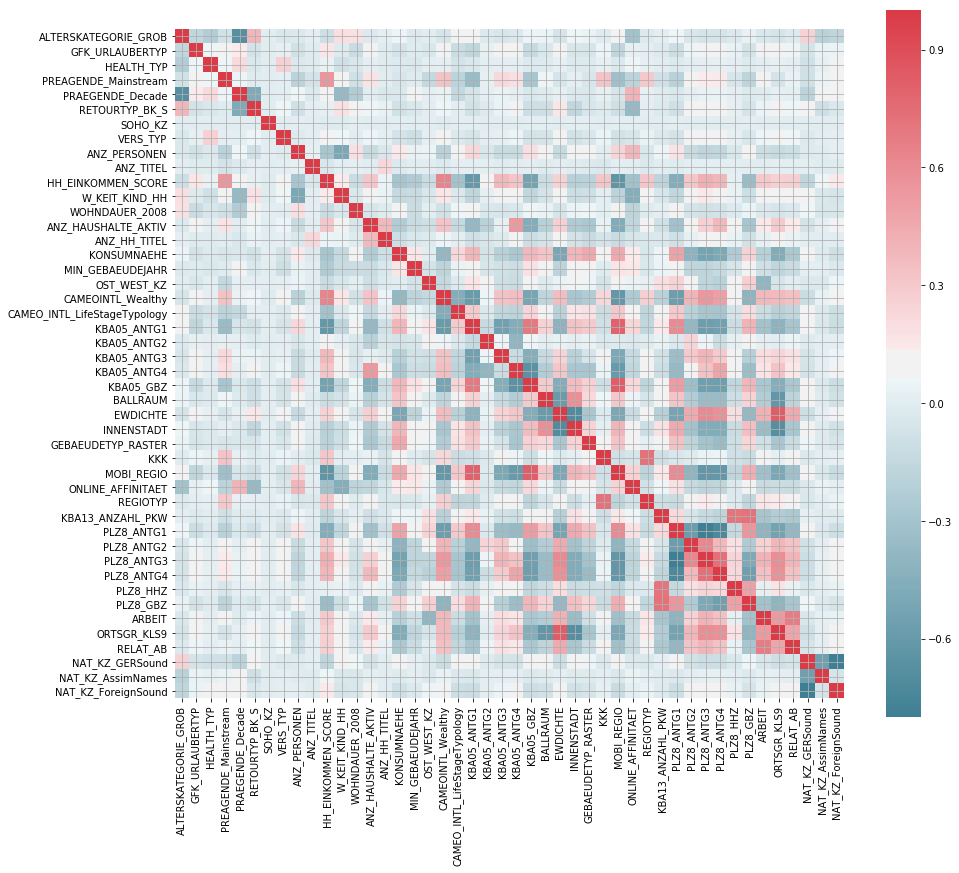

In [277]:
#Looking for highly correlated data
f, ax = plt.subplots(figsize=(15, 13))
corr = azdiasA.corr()
sns.heatmap(corr, mask=np.zeros_like(corr, dtype=np.bool), cmap=sns.diverging_palette(220, 10, as_cmap=True),
            square=True, ax=ax)
plt.grid()

As observed, there are not highly correlated data, and then, there is not required to drop any additional column. A look to the statistics of the dataframe can help us to find issues related with each of the dataframe columns, however, this is not the case.

In [278]:
azdiasA.describe()

,ALTERSKATEGORIE_GROB,GFK_URLAUBERTYP,HEALTH_TYP,PREAGENDE_Mainstream,PRAEGENDE_Decade,RETOURTYP_BK_S,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NAT_KZ_GERSound,NAT_KZ_AssimNames,NAT_KZ_ForeignSound
count,794642.000000,792792.000000,761009.000000,768968.000000,768968.000000,792792.000000,797426.000000,761009.000000,797426.000000,797426.000000,...,774697.000000,774697.000000,774697.00000,774697.000000,793208.000000,793308.000000,793208.000000,763793.000000,763793.000000,763793.000000
mean,2.795323,7.471097,2.199180,0.772205,73.319475,3.442797,0.008417,1.517945,1.729408,0.004152,...,1.595433,0.699170,3.61282,3.381081,3.166893,5.293621,3.071216,0.874077,0.042616,0.083307
std,1.018525,3.574764,0.755144,0.419410,14.574222,1.454499,0.091358,0.499678,1.156396,0.068551,...,0.986736,0.727138,0.97397,1.111598,0.999052,2.303275,1.360540,0.331763,0.201991,0.276345
min,1.000000,1.000000,1.000000,0.000000,40.000000,1.000000,0.000000,1.000000,0.000000,0.000000,...,0.000000,0.000000,1.00000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000
25%,2.000000,4.000000,2.000000,1.000000,60.000000,2.000000,0.000000,1.000000,1.000000,0.000000,...,1.000000,0.000000,3.00000,3.000000,3.000000,4.000000,2.000000,1.000000,0.000000,0.000000
50%,3.000000,8.000000,2.000000,1.000000,70.000000,4.000000,0.000000,2.000000,1.000000,0.000000,...,2.000000,1.000000,4.00000,3.000000,3.000000,5.000000,3.000000,1.000000,0.000000,0.000000
75%,4.000000,11.000000,3.000000,1.000000,90.000000,5.000000,0.000000,2.000000,2.000000,0.000000,...,2.000000,1.000000,4.00000,4.000000,4.000000,7.000000,4.000000,1.000000,0.000000,0.000000
max,4.000000,12.000000,3.000000,1.000000,90.000000,5.000000,1.000000,2.000000,45.000000,4.000000,...,3.000000,2.000000,5.00000,5.000000,5.000000,9.000000,5.000000,1.000000,1.000000,1.000000


###### Do whatever you need to in order to ensure that the dataframe only contains the columns that should be passed to the algorithm functions

In this part, the dataframe is analysed looking for columns that not contains the desired characteristics, mentioned at the beginning of this subsection. As observed in the next table, most of the columns in the dataframe are ordinal, a few of them are numerical, and some are categorical. The categorical type of columns is not required for this project, however, since the remaining categorical columns are binary there are no problems with the required characteristics.

In [279]:
Types = []
Columnas = []

for col in azdiasA.columns:
    
    if col in feat_info.attribute.values:
        Index = feat_info[feat_info.attribute == col].index.values[0]
        Types.append(feat_info.type.loc[Index])
        Columnas.append(col)

Typesd = {'Columns':Columnas, 'Type':Types}
        
TypesColumns = pd.DataFrame(Typesd)
TypesColumns

,Columns,Type
0,ALTERSKATEGORIE_GROB,ordinal
1,HEALTH_TYP,ordinal
2,RETOURTYP_BK_S,ordinal
3,SOHO_KZ,categorical
4,VERS_TYP,categorical
5,HH_EINKOMMEN_SCORE,ordinal
6,W_KEIT_KIND_HH,ordinal
7,WOHNDAUER_2008,ordinal
8,ANZ_HAUSHALTE_AKTIV,numeric
9,MIN_GEBAEUDEJAHR,numeric


### Step 1.3: Create a Cleaning Function

Even though you've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that you'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps you performed above. Then, when it comes to looking at the customer data in Step 3, you can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [114]:
def clean_data(df, feat_df, DictAttr, Steps):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT:      df: Demographics DataFrame
           feat_df: Daaframe containing codes for missing or unknown values
          DictAttr: Dictionary to conver codes to features in the df content
            Stepts: Columns with ouliers deleted for the general population dataframe
            
    OUTPUT: Trimmed and cleaned demographics DataFrame
                df: Demographics dataframe cleaned
    """
    
    # Put in code here to execute all main cleaning steps:
    #*******************************************************************************************************************
    # convert missing value codes into NaNs, ...
    #Removing brackets in the missing values column for their processing
    feat_df.missing_or_unknown = feat_df.missing_or_unknown.str.replace('[','').str.replace(']','')

    #Removing empty missing values codes
    feat_df.drop(feat_df[feat_df['missing_or_unknown'] == ''].index, inplace=True)

    #Creating a dictionary for processing the missing values codes
    Dict = {}

    for i, attribute in zip(feat_df.index,feat_df.attribute):
        Dict[attribute] = feat_df.missing_or_unknown.loc[i].split(',')

    #Finding columns with natural missing values in the df dataframe
    null_columns=df.columns[df.isnull().any()]

    #Finding the amount of natural missing values and the missing values related with the missing codes
    NatNaN = df.isnull().sum().values
    CodNaN = np.zeros(shape=df.shape[1])

    #Changing missing values codes with nan values
    for key in list(Dict.keys()):

        for n in Dict[key]: 
            if df[key].dtype == 'O':
                suma = df[key][df[key] == n].value_counts().sum()
                CodNaN[feat_df[feat_df['attribute'] ==key].index] += suma
                df[key] = df[key].replace(n,np.nan)
            else:
                suma = df[key][df[key] == int(n)].value_counts().sum()
                CodNaN[feat_df[feat_df['attribute'] ==key].index] += suma
                df[key] = df[key].replace(int(n),np.nan)
    
    #*******************************************************************************************************************
    # remove selected columns and rows, ...
    
    # Perform an assessment of how much missing data there is in each column of the dataset.
    null_columns=df.columns[df.isnull().any()]
    
    # Remove the outlier columns from the dataset. (You'll perform other data
    # engineering tasks such as re-encoding and imputation later.)
    df = df[Steps[0]]    
    
    # Write code to divide the data into two subsets based on the number of missing
    # values in each row.
    NullRowsA = df[(df.isnull().sum(1) <= 20)].index

    #*******************************************************************************************************************
    # select, re-encode, and engineer column values.
    CatRows = feat_df[feat_df.type == 'categorical'].index
    A = [col for col in feat_df.attribute.loc[CatRows] if col in df.columns]

    binary = []
    multi_level = []
    ReEnc = []
    
    for column in A:

        Code = df[column].unique()
        if len(Code) == 3:
            binary.append(column)
        else:
            multi_level.append(column)

        if ('O' in Code) or ('W' in Code):
            ReEnc.append(column)

    for n in range(len(binary)):
        if binary[n] in ReEnc:
            del binary[n]
            
    #-------------------------------------------------------------------------------------------------------------------
    #Re-Encoding non-numerical variables
    df['OST_WEST_KZ'].replace('O','0', inplace=True)
    df['OST_WEST_KZ'].replace('W','1', inplace=True)
    df['OST_WEST_KZ'].unique()

    #-------------------------------------------------------------------------------------------------------------------
    
    #Replacing codes with values from the data dictionary
    for key in list(DictAttr['NATIONALITAET_KZ'].keys()):
        df['NATIONALITAET_KZ'] = df['NATIONALITAET_KZ'].replace(float(key),DictAttr['NATIONALITAET_KZ'][key])
        
    #Creating dummies for the column features
    df = pd.get_dummies(df, columns=['NATIONALITAET_KZ'] , dummy_na=True) 

    #Assiging nan values to the rows of the dummies variables
    NaNindexs = df[df['NATIONALITAET_KZ_nan'] == 1].index
    columns = ['NATIONALITAET_KZ_German-sounding', 'NATIONALITAET_KZ_assimilatednames', 'NATIONALITAET_KZ_foreign-sounding']
    df[columns[0]].loc[NaNindexs] = np.nan
    df[columns[1]].loc[NaNindexs] = np.nan
    df[columns[2]].loc[NaNindexs] = np.nan

    #Dropping the nan dummie variable created
    df.drop('NATIONALITAET_KZ_nan', inplace=True, axis=1)

    #Renaming the created dummies variables
    df = df.rename(columns={columns[0]: 'NAT_KZ_GERSound', columns[1]: 'NAT_KZ_AssimNames', columns[2]:'NAT_KZ_ForeignSound'})

    #Removing NATIONALITAET_KZ_nan from the multi_level list
    for n in range(len(multi_level)):
        if multi_level[n] == 'NATIONALITAET_KZ':
            NIndex = n

    del multi_level[NIndex]

    #-------------------------------------------------------------------------------------------------------------------
    #Dropping the rest of the multi-level categorical features

    for col in multi_level:
        df.drop(col, inplace=True, axis=1)
        feat_df.drop(feat_df[feat_df['missing_or_unknown'] == ''].index, inplace=True)

    #-------------------------------------------------------------------------------------------------------------------
    #Inserting column for the categorical binary data#
    columns = df.columns
    Index = [n for n in range(len(columns)) if columns[n] == 'PRAEGENDE_JUGENDJAHRE']    
 
    df.insert(loc=Index[0], column='PREAGENDE_Mainstream', value=df.PRAEGENDE_JUGENDJAHRE.values)
    
    #Generating the content for the 'PRAEGENDE_JUGENDJAHRE' and 'PREAGENDE_Mainstream' columns
    Movement = []
    for key in list(DictAttr['PRAEGENDE_JUGENDJAHRE'].keys()):
        loc = DictAttr['PRAEGENDE_JUGENDJAHRE'][key].find(',')
        Vals = DictAttr['PRAEGENDE_JUGENDJAHRE'][key][0:loc].split('(')

        if len(Vals)>1:
            Vals[0] = Vals[0].split('-')[0].replace('s', '')
            df['PRAEGENDE_JUGENDJAHRE'] = df['PRAEGENDE_JUGENDJAHRE'].replace(float(key),Vals[0])
            df['PREAGENDE_Mainstream'] = df['PREAGENDE_Mainstream'].replace(float(key),Vals[1])

    #Re-encoding the Mainstream / Avantgarde column for numerical values
    df['PREAGENDE_Mainstream'].replace('Mainstream', 1, inplace=True)
    df['PREAGENDE_Mainstream'].replace('Avantgarde', 0, inplace=True)
    
    df = df.rename(columns={'PRAEGENDE_JUGENDJAHRE': 'PRAEGENDE_Decade'})
    
    NewColumns = ['PREAGENDE_Mainstream','PRAEGENDE_Decade']
    #-------------------------------------------------------------------------------------------------------------------
    #Inserting column for the categorical binary data
    columns = df.columns
    Index = [n for n in range(len(columns)) if columns[n] == 'CAMEO_INTL_2015']    
    
    df.insert(loc=Index[0], column='CAMEOINTL_Wealthy', value=df.CAMEO_INTL_2015.values)
    
    Movement = []
    for key in list(DictAttr['CAMEO_INTL_2015'].keys()):
        loc = DictAttr['CAMEO_INTL_2015'][key].find('-')
        Vals = DictAttr['CAMEO_INTL_2015'][key].split('s-')

        if key not in ['XX', '-1']:

            if len(Vals)>1:
                df['CAMEOINTL_Wealthy'] = df['CAMEOINTL_Wealthy'].replace(key,int(int(key)/10))
                df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].replace(key,int(key)-int(int(key)/10)*10)

    df = df.rename(columns={'CAMEO_INTL_2015': 'CAMEO_INTL_LifeStageTypology'})

    #-------------------------------------------------------------------------------------------------------------------
    #Dropping the rest of the mixed columns
    Mixed = []

    for col in df.columns:

        if col in feat_df.attribute.values:
            Index = feat_df[feat_df.attribute == col].index.values[0]
            if feat_df.type.loc[Index] == 'mixed':
                Mixed.append(col)

    for col in Mixed:
        df.drop(col, inplace=True, axis=1)
        
    #*******************************************************************************************************************
    # Return the cleaned dataframe.
    
    df = df.loc[NullRowsA]
    
    return df
    

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, you'll want to keep an eye on the [API reference page for sklearn](http://scikit-learn.org/stable/modules/classes.html) to help you navigate to all of the classes and functions that you'll need. In this substep, you'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to your data, make sure that you've cleaned the DataFrame of the remaining missing values. This can be as simple as just removing all data points with missing data, or applying an [Imputer](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.Imputer.html) to replace all missing values. You might also try a more complicated procedure where you temporarily remove missing values in order to compute the scaling parameters before re-introducing those missing values and applying imputation. Think about how much missing data you have and what possible effects each approach might have on your analysis, and justify your decision in the discussion section below.
- For the actual scaling function, a [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html) instance is suggested, scaling each feature to mean 0 and standard deviation 1.
- For these classes, you can make use of the `.fit_transform()` method to both fit a procedure to the data as well as apply the transformation to the data at the same time. Don't forget to keep the fit sklearn objects handy, since you'll be applying them to the customer demographics data towards the end of the project.

In the next figure are presented the proportion of missing values on each of the general population dataframe columns, with respect with all population used to create the dataframe.

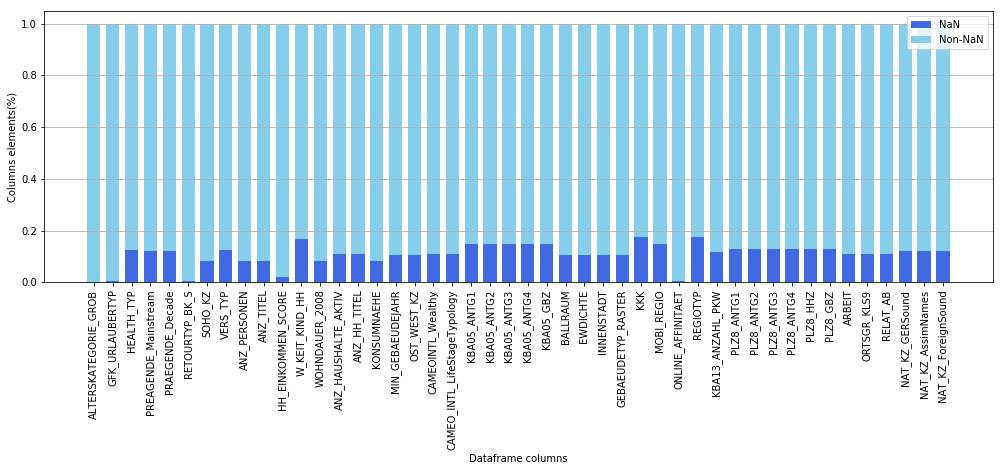

In [115]:
azdias.shape
NaNVector = azdias.isnull().sum().values
NonNaNVec = azdias.shape[0] - azdias.isnull().sum().values

fig, ax1 = plt.subplots(figsize=(17,5))
width = 0.7
p1 = plt.bar(azdias.columns, NaNVector/azdias.shape[0], width, color='royalblue')
p2 = plt.bar(azdias.columns, NonNaNVec/azdias.shape[0], width, bottom=NaNVector/azdias.shape[0], color='skyblue')
plt.xticks(rotation=90);
plt.grid(axis='y')
plt.ylabel('Columns elements(%)');
plt.xlabel('Dataframe columns');
plt.legend((p1[0], p2[0]), ('NaN', 'Non-NaN'));

It was observed in the previous figure that most of the columns possess the same amount of missing values, with few exceptions. However, that does not imply that their *nan* values are related to some extent. Nonetheless, a complementary analysis can be implemented as follow:

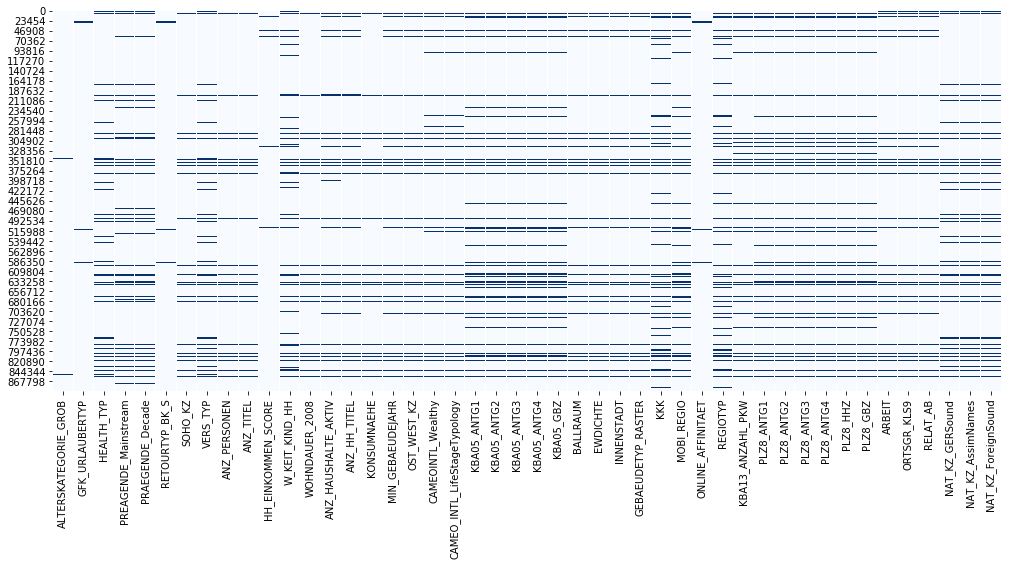

In [116]:
fig, ax = plt.subplots(figsize=(17,7))  
sns.heatmap(azdias.isnull(), cbar=False,cmap="Blues");

It is possible to determine, by observing the previous figure, that missing values in the rows of the azdias dataframe are related to some extend, and then, the effect deleting them wont be great since most of the columns will be affected similarly. Thus, rows containing *nan* values will be dropped as follow:

In [117]:
# If you've not yet cleaned the dataset of all NaN values, then investigate and
# do that now.
azdias= azdiasA
azdias.dropna(inplace=True) 
azdias.astype(int, inplace=True);

In order to use the processed dataframe the values of its columns need to be similar, especially for the use pf PCA, which is affected greatly by values with different ranges and variances. Then, the use of a StandarScaler technique helps to adequate the data for its use on PCA, as presented next:

In [118]:
columns = azdias.columns
scaler = StandardScaler()
azdias[columns] = scaler.fit_transform(azdias[columns])
azdias.describe()

C:\Users\alfonso\Anaconda3\lib\site-packages\sklearn\preprocessing\data.py:625: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
C:\Users\alfonso\Anaconda3\lib\site-packages\sklearn\base.py:462: DataConversionWarning: Data with input dtype int32, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


,ALTERSKATEGORIE_GROB,GFK_URLAUBERTYP,HEALTH_TYP,PREAGENDE_Mainstream,PRAEGENDE_Decade,RETOURTYP_BK_S,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NAT_KZ_GERSound,NAT_KZ_AssimNames,NAT_KZ_ForeignSound
count,6.232110e+05,6.232110e+05,6.232110e+05,6.232110e+05,6.232110e+05,6.232110e+05,6.232110e+05,6.232110e+05,6.232110e+05,6.232110e+05,...,6.232110e+05,6.232110e+05,6.232110e+05,6.232110e+05,6.232110e+05,6.232110e+05,6.232110e+05,6.232110e+05,6.232110e+05,6.232110e+05
mean,-1.478238e-16,-9.393547e-17,-1.338429e-16,8.687805e-17,3.680346e-16,-7.584157e-17,-1.258706e-17,-1.834814e-16,-5.152256e-17,-9.394687e-18,...,-1.845018e-17,-1.485307e-17,-9.591930e-17,-1.031819e-17,-1.787841e-16,1.687067e-16,-1.636944e-16,6.376188e-17,3.501345e-17,-1.176046e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,...,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.746287e+00,-1.824827e+00,-1.591635e+00,-1.806125e+00,-2.280170e+00,-1.665693e+00,-9.257839e-02,-1.066793e+00,-7.191211e-01,-6.073220e-02,...,-1.658144e+00,-9.819730e-01,-2.721004e+00,-2.111170e+00,-2.223015e+00,-1.914219e+00,-1.563993e+00,-2.609458e+00,-2.084343e-01,-3.075569e-01
25%,-7.720894e-01,-9.768193e-01,-2.734945e-01,5.536715e-01,-9.023201e-01,-9.781753e-01,-9.257839e-02,-1.066793e+00,-7.191211e-01,-6.073220e-02,...,-6.419951e-01,-9.819730e-01,-6.397007e-01,-3.147647e-01,-2.011747e-01,-6.074371e-01,-8.238409e-01,3.832214e-01,-2.084343e-01,-3.075569e-01
50%,2.021080e-01,1.538574e-01,-2.734945e-01,5.536715e-01,-2.133950e-01,3.968602e-01,-9.257839e-02,9.373888e-01,-7.191211e-01,-6.073220e-02,...,3.741537e-01,3.846711e-01,-6.397007e-01,-3.147647e-01,-2.011747e-01,-1.718433e-01,-8.368848e-02,3.832214e-01,-2.084343e-01,-3.075569e-01
75%,1.176305e+00,1.001865e+00,1.044646e+00,5.536715e-01,1.164455e+00,1.084378e+00,-9.257839e-02,9.373888e-01,1.706320e-01,-6.073220e-02,...,3.741537e-01,3.846711e-01,4.009511e-01,5.834381e-01,8.097453e-01,6.993443e-01,6.564639e-01,3.832214e-01,-2.084343e-01,-3.075569e-01
max,1.176305e+00,1.284534e+00,1.044646e+00,5.536715e-01,1.164455e+00,1.084378e+00,1.080166e+01,9.373888e-01,3.220175e+01,5.848370e+01,...,1.390302e+00,1.751315e+00,1.441603e+00,1.481641e+00,1.820665e+00,1.570532e+00,1.396616e+00,3.832214e-01,4.797675e+00,3.251431e+00


### Discussion 2.1: Apply Feature Scaling

The missing or unknown values found on each of the dataframe rows were dropped, as explained through the section, the effect of dropping dataframe rows with missing values is similar through all columns, and therefore, it won’t change the columns importance or create bias toward specific features. The feature scaling was used to adequate que data for the implementation of the PCA algorithm, by subtracting the columns means and reducing their variances.

### Step 2.2: Perform Dimensionality Reduction

On your scaled data, you are now ready to apply dimensionality reduction techniques.

- Use sklearn's [PCA](http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data. To start, you should not set any parameters (so all components are computed) or set a number of components that is at least half the number of features (so there's enough features to see the general trend in variability).
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Try plotting the cumulative or sequential values using matplotlib's [`plot()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.plot.html) function. Based on what you find, select a value for the number of transformed features you'll retain for the clustering part of the project.
- Once you've made a choice for the number of components to keep, make sure you re-fit a PCA instance to perform the decided-on transformation.

In [52]:
# Apply PCA to the data.
columns = azdias.columns
pca = PCA()
pca.fit(azdias[columns])

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
  svd_solver='auto', tol=0.0, whiten=False)

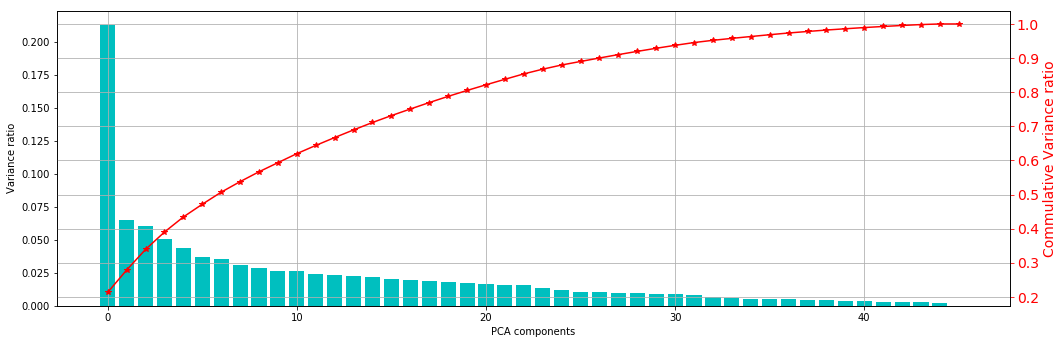

In [53]:
# Investigate the variance accounted for by each principal component.
VarRat = pca.explained_variance_ratio_

Suma = 0
VarRatAcum = []

for var in pca.explained_variance_ratio_:
    Suma+=var
    VarRatAcum.append(Suma)

PCAvariance(VarRat, VarRatAcum)

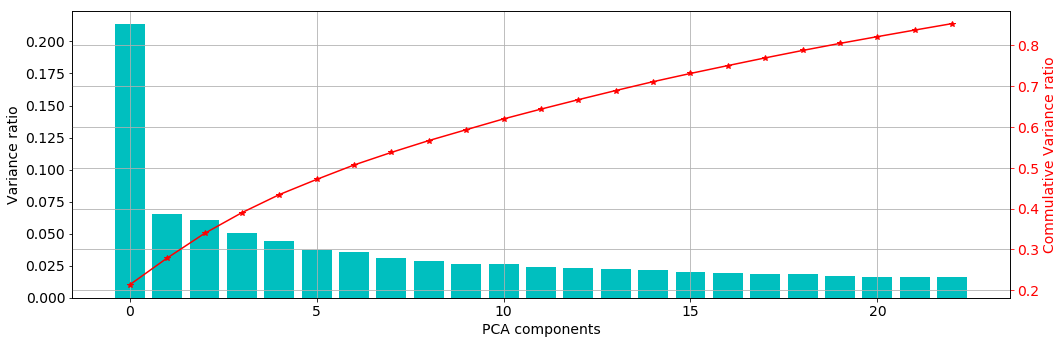

In [61]:
# Re-apply PCA to the data while selecting for number of components to retain.

pca = PCA(n_components=23)

pca.fit(azdias[columns])

dfPCA = pca.transform(azdias[columns])

VarRat = pca.explained_variance_ratio_

Suma = 0
VarRatAcum = []

for var in pca.explained_variance_ratio_:
    Suma+=var
    VarRatAcum.append(Suma)

PCAvariance(VarRat, VarRatAcum)

### Discussion 2.2: Perform Dimensionality Reduction

It was found that half of the cumulative variance for the pca components is generated from the first 10 PCA components of the processed dataframe. Following what it was explained in the Udacity Data Science lectures, the first 32 components of the processed dataframe were selected to explain at least 85 % of the total components variance. Then, the next analysis will be implemented considering only the mentioned components.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

- To investigate the features, you should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list. Use the data dictionary document to help you understand these most prominent features, their relationships, and what a positive or negative value on the principal component might indicate.
- You should investigate and interpret feature associations from the first three principal components in this substep. To help facilitate this, you should write a function that you can call at any time to print the sorted list of feature weights, for the *i*-th principal component. This might come in handy in the next step of the project, when you interpret the tendencies of the discovered clusters.

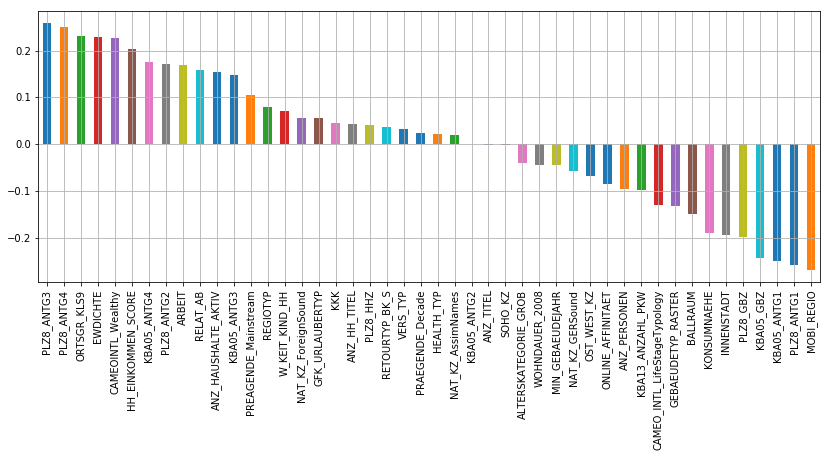

In [62]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that you can reuse in the
# other cells.

def PCAcompWeights(pca, df, component, plot=False):
    
    #Creating a dataframe with the pca components
    componentsA = pd.DataFrame(np.round(pca.components_, 4), columns = azdias.keys())
    
    #Generating a copy of the created dataframe
    components = componentsA.copy()
    
    #Sorting the weigths for the required pca component
    components.sort_values(by=component-1, ascending=False, axis=1, inplace=True)

    #Printing the sorted pca weights for the required component
    if plot==False:
        print(components.loc[component-1].transpose())
    
    #Plotting the sorted pca weights for the required component 
    if plot==True:
        plt.rcParams.update({'font.size': 10})
        fig, ax = plt.subplots(figsize = (14,5))
        components.loc[component-1].plot(ax = ax, kind = 'bar');
        plt.grid()

PCAcompWeights(pca, azdias, 1, plot=True)


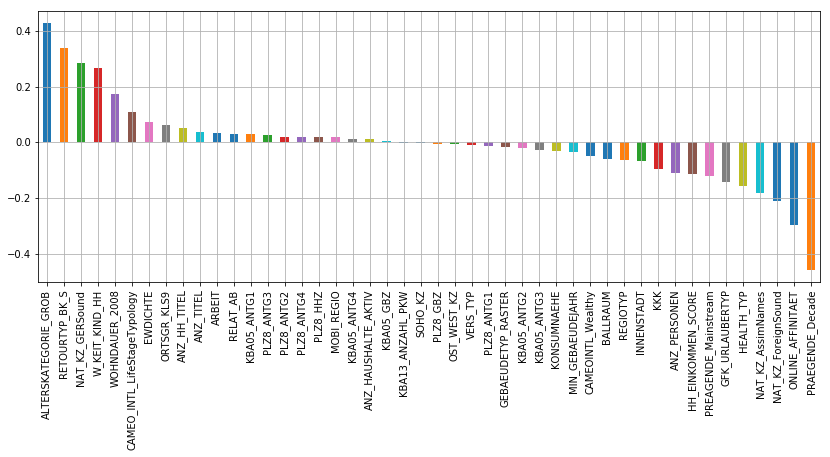

In [63]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

PCAcompWeights(pca, azdias, 2, plot=True)

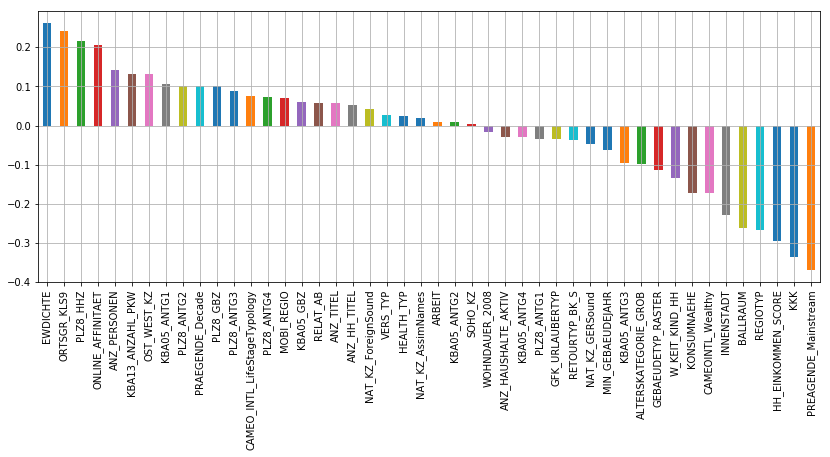

In [64]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

PCAcompWeights(pca, azdias, 3, plot=True)

### Discussion 2.3: Interpret Principal Components

It can be observed that the first component is closely related with the number of more than 3 family houses in the PLZ8 region. It is also affected by the pattern of movements, its negative effect in the component can be because of the lack of movement patterns. This may apply also to the lack of number of houses with 1-2 family members in the PLZ8 region and in the microcell. Nonetheless, the component is affected by most of the attributes in the dataframe, but the mentioned attributes are those that shown more effect on the component.

For the second component, it can be observed that is affected positively by the edge of the population, by the type of return, by the sound of the population’s names and by how long the population have been living there. On the other hand, this component is affected negatively by the decade that identifies the population and by their online affinity, it may be negative because of the age of the population living there and the lack of interest on the internet. 

Lastly, the third component depends heavily on the density of houses per square kilometre, on the size of the community, the number of houses in the region PLZ8 and on the population’s Internet's affinity. However, this component is affected negatively by the Dominating movement of person's youth, the purchasing power in the region, and the household estimated incomes. The negative effect may be result from low household incomes, low purchasing power and not the desired person’s movements that identified them when they were young.

## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

You've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, you will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's [KMeans](http://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html#sklearn.cluster.KMeans) class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center. **Hint**: The KMeans object's `.score()` method might be useful here, but note that in sklearn, scores tend to be defined so that larger is better. Try applying it to a small, toy dataset, or use an internet search to help your understanding.
- Perform the above two steps for a number of different cluster counts. You can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data. **Warning**: because of the large size of the dataset, it can take a long time for the algorithm to resolve. The more clusters to fit, the longer the algorithm will take. You should test for cluster counts through at least 10 clusters to get the full picture, but you shouldn't need to test for a number of clusters above about 30.
- Once you've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that you also obtain the cluster assignments for the general demographics data, since you'll be using them in the final Step 3.3.

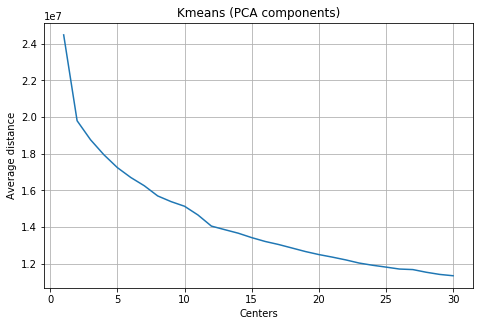

In [72]:
# Over a number of different cluster counts...
# run k-means clustering on the data and...
# compute the average within-cluster distances.
    
n_scor = [30]

PCATest(dfPCA, n_scor, dfPCA.shape[0], layout=(1,1), Figsize=(7,4))

# Investigate the change in within-cluster distance across number of clusters.
# HINT: Use matplotlib's plot function to visualize this relationship.

The previous figures show distances among clusters and their elements. Then, after estimating the elbow effect, it was decided to use 12 clusters.

In [73]:
# Re-fit the k-means model with the selected number of clusters and obtain
# cluster predictions for the general population demographics data.
kmeans = KMeans(12, random_state=0)
model = kmeans.fit(dfPCA)
PredAzdias = model.predict(dfPCA)

### Discussion 3.1: Apply Clustering to General Population

The elbow effect is difficult to see in the previously presented plots. The metric used to find the average distance between the centroids and their selected elements was the *scikitlearn* *kmean* inertia parameter, which is defined as the sum of squared distances of samples to their closet cluster center, which is the opposite of the score metric definition. In this case, 23 clusters were selected to organize the 32 selected *PCA* components, due that, in the 23rd cluster was the last most significant change of distance in the previous figures.

### Step 3.2: Apply All Steps to the Customer Data

Now that you have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, you're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, you will interpret how the general population fits apply to the customer data.

- Don't forget when loading in the customers data, that it is semicolon (`;`) delimited.
- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function you created earlier. (You can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, you should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should you be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [123]:
# Load in the customer demographics data.
customers = customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';')
print(customers.shape)

(191652, 85)


In [124]:
# Apply preprocessing, feature transformation

customers = clean_data(customers, feat_info, DictAttr, Steps)
print(customers.shape)

customers.dropna(inplace=True) 
customers.astype(int, inplace=True);

columns = customers.columns
customers[columns] = scaler.transform(customers[columns])

dfPCAC = pca.transform(customers[columns])

customers.describe()

C:\Users\alfonso\Anaconda3\lib\site-packages\ipykernel_launcher.py:81: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
C:\Users\alfonso\Anaconda3\lib\site-packages\pandas\core\generic.py:5890: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)
C:\Users\alfonso\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
C:\Users\alfonso\Anaconda3\lib\site-packages\ipykernel_launcher.py:98: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

(141640, 46)


C:\Users\alfonso\Anaconda3\lib\site-packages\ipykernel_launcher.py:10: DataConversionWarning: Data with input dtype float64, object were all converted to float64 by StandardScaler.
  # Remove the CWD from sys.path while we load stuff.


,ALTERSKATEGORIE_GROB,GFK_URLAUBERTYP,HEALTH_TYP,PREAGENDE_Mainstream,PRAEGENDE_Decade,RETOURTYP_BK_S,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NAT_KZ_GERSound,NAT_KZ_AssimNames,NAT_KZ_ForeignSound
count,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,...,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000,115643.000000
mean,0.717609,-0.243003,-0.334031,-0.700861,-1.010237,0.340773,0.014063,-0.061661,0.526132,0.261750,...,-0.236363,-0.239355,0.017871,0.234613,-0.366140,-0.100735,-0.141688,0.305223,-0.161032,-0.248498
std,0.659671,0.872540,1.009453,1.177541,0.907508,0.814967,1.072571,1.002091,1.185437,2.320091,...,0.897252,0.872231,0.962511,0.904215,1.016550,0.940271,1.051078,0.476803,0.484824,0.454645
min,-1.746287,-1.824827,-1.591635,-1.806125,-2.280170,-1.665693,-0.092578,-1.066793,-0.719121,-0.060732,...,-1.658144,-0.981973,-2.721004,-2.111170,-2.223015,-1.914219,-1.563993,-2.609458,-0.208434,-0.307557
25%,0.202108,-0.976819,-1.591635,-1.806125,-1.591245,-0.290658,-0.092578,-1.066793,-0.719121,-0.060732,...,-0.641995,-0.981973,-0.639701,-0.314765,-1.212095,-0.607437,-0.823841,0.383221,-0.208434,-0.307557
50%,1.176305,-0.128812,-0.273495,-1.806125,-0.902320,0.396860,-0.092578,0.937389,0.170632,-0.060732,...,-0.641995,-0.981973,-0.639701,0.583438,-0.201175,-0.171843,-0.083688,0.383221,-0.208434,-0.307557
75%,1.176305,0.719196,1.044646,0.553672,-0.213395,1.084378,-0.092578,0.937389,1.060385,-0.060732,...,0.374154,0.384671,0.400951,0.583438,0.809745,0.699344,0.656464,0.383221,-0.208434,-0.307557
max,1.176305,1.284534,1.044646,0.553672,1.164455,1.084378,10.801657,0.937389,17.075942,73.119804,...,1.390302,1.751315,1.441603,1.481641,1.820665,1.570532,1.396616,0.383221,4.797675,3.251431


In [125]:
#Obtaining cluster predictions for the customer demographics data.
PreCustomers = model.predict(dfPCAC)


In [126]:
PreCustomers.shape

(115643,)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, you have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, you will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups. Seaborn's [`countplot()`](https://seaborn.pydata.org/generated/seaborn.countplot.html) or [`barplot()`](https://seaborn.pydata.org/generated/seaborn.barplot.html) function could be handy.
  - Recall the analysis you performed in step 1.1.3 of the project, where you separated out certain data points from the dataset if they had more than a specified threshold of missing values. If you found that this group was qualitatively different from the main bulk of the data, you should treat this as an additional data cluster in this analysis. Make sure that you account for the number of data points in this subset, for both the general population and customer datasets, when making your computations!
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help you make this inference. Alternatively, you can use the `.inverse_transform()` method of the PCA and StandardScaler objects to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

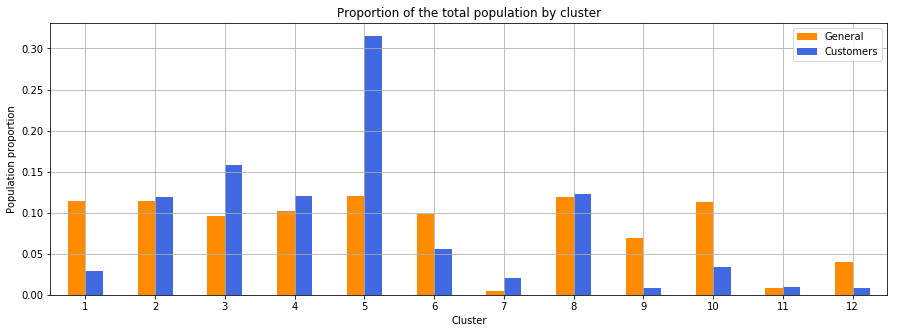

In [128]:
# Compare the proportion of data in each cluster for the customer data to the
# proportion of data in each cluster for the general population.
CountsGen = []
CountsCus = []

for n in range(12):
    
    CountsGen.append(sum(PredAzdias == n)/len(PredAzdias))
    CountsCus.append(sum(PreCustomers == n)/len(PreCustomers))
    
d= {'Cluster':range(1,13), 'General': CountsGen, 'Customers': CountsCus}
General = pd.DataFrame(d)

General.plot(x='Cluster', y = ['General', 'Customers'], kind='bar', figsize=(15,5), color=['darkorange', 'royalblue'])
plt.xticks(rotation=0);
plt.ylabel('Population proportion');
plt.title('Proportion of the total population by cluster')
plt.grid()

##### Overrepresented case

In [234]:
# What kinds of people are part of a cluster that is overrepresented in the
# customer data compared to the general population?
dataOverA = scaler.inverse_transform(pca.inverse_transform(dfPCAC[np.where(PreCustomers==5)])).round()
dataOverA = pd.DataFrame(data=dataOverA, columns=customers.columns)
dataOverA = dataOverA.astype(int)

#Replacing attributes with data dictionary

for column in dataOverA.columns:
    if column in list(DictAttr.keys()):
        for key in DictAttr[column].keys():
            #print(key, DictAttr[column][key])
            if key not in ['O', 'W']:
                dataOverA[column] = dataOverA[column].replace(int(key),DictAttr[column][key])
            
dataOverA.head()

,ALTERSKATEGORIE_GROB,GFK_URLAUBERTYP,HEALTH_TYP,PREAGENDE_Mainstream,PRAEGENDE_Decade,RETOURTYP_BK_S,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NAT_KZ_GERSound,NAT_KZ_AssimNames,NAT_KZ_ForeignSound
0,46-60yearsold,Eventtravelers,3,1,69,determinedMinimal-Returner,nosmalloffice/homeoffice,individualistic-acceptingrisks,1,0,...,highshareof6-10familyhomes,highshareof10+familyhomes,600-849households,130-299buildings,high,">700,000inhabitants",high,1,0,0
1,46-60yearsold,Culturelovers,criticalreserved,1,69,incentive-receptiveNormal-Returner,nosmalloffice/homeoffice,individualistic-acceptingrisks,2,0,...,highshareof6-10familyhomes,highshareof10+familyhomes,600-849households,60-129buildings,high,"100,001to300,000inhabitants",average,1,0,0
2,>60yearsold,Culturelovers,criticalreserved,0,50,conservativeLow-Returner,nosmalloffice/homeoffice,social-safetydriven,2,0,...,averageshareof6-10familyhomes,lowershareof10+familyhomes,300-599households,60-129buildings,average,"300,001to700,000inhabitants",high,1,0,0
3,30-45yearsold,Packagetourtravelers,sanitaryaffine,1,75,incentive-receptiveNormal-Returner,nosmalloffice/homeoffice,social-safetydriven,1,0,...,highshareof6-10familyhomes,highshareof10+familyhomes,morethan849households,130-299buildings,high,">700,000inhabitants",average,1,0,0
4,<30yearsold,Packagetourtravelers,3,1,97,incentive-receptiveNormal-Returner,nosmalloffice/homeoffice,social-safetydriven,2,0,...,averageshareof6-10familyhomes,highshareof10+familyhomes,600-849households,60-129buildings,high,">700,000inhabitants",average,1,0,0


In [232]:
#overrepresented Features:
dataOverA.ALTERSKATEGORIE_GROB.value_counts()

>60yearsold      3719
46-60yearsold    2106
30-45yearsold     514
5                 102
<30yearsold        46
6                   1
Name: ALTERSKATEGORIE_GROB, dtype: int64

In [233]:
dataOverA.GFK_URLAUBERTYP.value_counts()

Connoisseurs                      1183
Culturelovers                     1092
Wintersportspeople                1013
Homeland-connectedvacationists     730
Activefamilies                     602
Naturefans                         514
Withoutvacation                    442
Family-orientedvacationists        310
Packagetourtravelers               217
Goldenager                         194
Eventtravelers                      92
Hiker                               89
13                                  10
Name: GFK_URLAUBERTYP, dtype: int64

In [235]:
dataUnderA = scaler.inverse_transform(pca.inverse_transform(dfPCA[np.where(PredAzdias==5)])).round()
dataUnderA = pd.DataFrame(data=dataUnderA, columns=azdias.columns)
dataUnderA = dataUnderA.astype(int)

#Replacing attributes with data dictionary
for column in dataUnderA.columns:
    if column in list(DictAttr.keys()):
        for key in DictAttr[column].keys():
            #print(key, DictAttr[column][key])
            if key not in ['O', 'W']:
                dataUnderA[column] = dataUnderA[column].replace(int(key),DictAttr[column][key])
                
dataUnderA.head()

,ALTERSKATEGORIE_GROB,GFK_URLAUBERTYP,HEALTH_TYP,PREAGENDE_Mainstream,PRAEGENDE_Decade,RETOURTYP_BK_S,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NAT_KZ_GERSound,NAT_KZ_AssimNames,NAT_KZ_ForeignSound
0,30-45yearsold,Withoutvacation,3,1,80,incentive-receptiveNormal-Returner,nosmalloffice/homeoffice,individualistic-acceptingrisks,2,0,...,averageshareof6-10familyhomes,lowershareof10+familyhomes,600-849households,130-299buildings,average,"10,001to20,000inhabitants",average,1,0,0
1,46-60yearsold,Withoutvacation,3,0,69,conservativeLow-Returner,nosmalloffice/homeoffice,individualistic-acceptingrisks,1,0,...,averageshareof6-10familyhomes,highshareof10+familyhomes,300-599households,lessthan60buildings,average,10,high,1,0,0
2,>60yearsold,Eventtravelers,sanitaryaffine,1,60,determinedMinimal-Returner,nosmalloffice/homeoffice,social-safetydriven,1,0,...,highshareof6-10familyhomes,highshareof10+familyhomes,600-849households,60-129buildings,average,"100,001to300,000inhabitants",average,1,0,0
3,46-60yearsold,Eventtravelers,criticalreserved,1,69,incentive-receptiveNormal-Returner,nosmalloffice/homeoffice,individualistic-acceptingrisks,3,0,...,highshareof6-10familyhomes,highshareof10+familyhomes,600-849households,60-129buildings,high,">700,000inhabitants",veryhigh,1,0,0
4,46-60yearsold,Connoisseurs,3,1,70,determinedMinimal-Returner,nosmalloffice/homeoffice,individualistic-acceptingrisks,1,0,...,highshareof6-10familyhomes,highshareof10+familyhomes,300-599households,lessthan60buildings,average,">700,000inhabitants",high,1,0,0


In [227]:
#Important characteristics of underrepresented people
dataUnderA.ALTERSKATEGORIE_GROB.value_counts()

46-60yearsold    23434
30-45yearsold    17863
>60yearsold      16128
<30yearsold       4022
5                  193
Name: ALTERSKATEGORIE_GROB, dtype: int64

In [228]:
dataUnderA.GFK_URLAUBERTYP.value_counts()

Withoutvacation                   11278
Connoisseurs                      10264
Culturelovers                      8338
Activefamilies                     7813
Homeland-connectedvacationists     6094
Wintersportspeople                 4889
Packagetourtravelers               3199
Naturefans                         3127
Family-orientedvacationists        2170
Eventtravelers                     1730
Goldenager                         1392
Hiker                               800
13                                  522
0                                    17
14                                    7
Name: GFK_URLAUBERTYP, dtype: int64

##### Underrepresented case

In [135]:
# What kinds of people are part of a cluster that is underrepresented in the
# customer data compared to the general population?
dataUnderB = scaler.inverse_transform(pca.inverse_transform(dfPCAC[np.where(PreCustomers==0)])).round()
dataUnderB = pd.DataFrame(data=dataUnderB, columns=customers.columns)
dataUnderB = dataUnderB.astype(int)

#Replacing attributes with data dictionary

for column in dataUnderB.columns:
    if column in list(DictAttr.keys()):
        for key in DictAttr[column].keys():
            #print(key, DictAttr[column][key])
            if key not in ['O', 'W']:
                dataUnderB[column] = dataUnderB[column].replace(int(key),DictAttr[column][key])
            
dataUnderB.head(5)

,ALTERSKATEGORIE_GROB,GFK_URLAUBERTYP,HEALTH_TYP,PREAGENDE_Mainstream,PRAEGENDE_Decade,RETOURTYP_BK_S,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NAT_KZ_GERSound,NAT_KZ_AssimNames,NAT_KZ_ForeignSound
0,46-60yearsold,Hiker,3,1,78,incentive-receptiveNormal-Returner,nosmalloffice/homeoffice,individualistic-acceptingrisks,1,0,...,averageshareof6-10familyhomes,lowershareof10+familyhomes,600-849households,300-449buildings,average,"20,001to50,000inhabitants",high,1,0,0
1,46-60yearsold,Culturelovers,3,1,74,determinedMinimal-Returner,nosmalloffice/homeoffice,social-safetydriven,2,0,...,averageshareof6-10familyhomes,lowershareof10+familyhomes,600-849households,300-449buildings,average,"50,001to100,000inhabitants",average,1,0,0
2,46-60yearsold,Homeland-connectedvacationists,sanitaryaffine,1,69,conservativeLow-Returner,nosmalloffice/homeoffice,social-safetydriven,2,0,...,lowershareof6-10familyhomes,no10+familyhomes,morethan849households,morethan449buildings,average,"100,001to300,000inhabitants",high,1,0,0
3,46-60yearsold,Connoisseurs,sanitaryaffine,1,70,conservativeLow-Returner,nosmalloffice/homeoffice,social-safetydriven,3,0,...,averageshareof6-10familyhomes,lowershareof10+familyhomes,6,morethan449buildings,low,"20,001to50,000inhabitants",low,1,0,0
4,30-45yearsold,Connoisseurs,3,1,77,incentive-receptiveNormal-Returner,nosmalloffice/homeoffice,individualistic-acceptingrisks,1,0,...,lowershareof6-10familyhomes,no10+familyhomes,600-849households,300-449buildings,high,"20,001to50,000inhabitants",veryhigh,1,0,0


In [236]:
dataUnderB.GFK_URLAUBERTYP.value_counts()

Connoisseurs                      669
Homeland-connectedvacationists    501
Withoutvacation                   479
Activefamilies                    391
Packagetourtravelers              234
Naturefans                        217
Culturelovers                     193
Eventtravelers                    157
Wintersportspeople                156
Goldenager                        105
Family-orientedvacationists        96
Hiker                              87
13                                 17
0                                   3
Name: GFK_URLAUBERTYP, dtype: int64

In [237]:
dataUnderB.	ALTERSKATEGORIE_GROB.value_counts()

46-60yearsold    1933
30-45yearsold     816
>60yearsold       487
<30yearsold        66
5                   3
Name: ALTERSKATEGORIE_GROB, dtype: int64

In [137]:
dataOverB = scaler.inverse_transform(pca.inverse_transform(dfPCA[np.where(PredAzdias==0)])).round()
dataOverB = pd.DataFrame(data=dataOverB, columns=azdias.columns)
dataOverB = dataOverB.astype(int)

#Replacing attributes with data dictionary

for column in dataOverB.columns:
    if column in list(DictAttr.keys()):
        for key in DictAttr[column].keys():
            #print(key, DictAttr[column][key])
            if key not in ['O', 'W']:
                dataOverB[column] = dataOverB[column].replace(int(key),DictAttr[column][key])
            
dataOverB.head()

,ALTERSKATEGORIE_GROB,GFK_URLAUBERTYP,HEALTH_TYP,PREAGENDE_Mainstream,PRAEGENDE_Decade,RETOURTYP_BK_S,SOHO_KZ,VERS_TYP,ANZ_PERSONEN,ANZ_TITEL,...,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB,NAT_KZ_GERSound,NAT_KZ_AssimNames,NAT_KZ_ForeignSound
0,30-45yearsold,Withoutvacation,sanitaryaffine,1,79,conservativeLow-Returner,nosmalloffice/homeoffice,social-safetydriven,1,0,...,lowershareof6-10familyhomes,no10+familyhomes,morethan849households,morethan449buildings,high,"20,001to50,000inhabitants",high,1,0,0
1,46-60yearsold,13,sanitaryaffine,0,75,incentive-receptiveNormal-Returner,nosmalloffice/homeoffice,individualistic-acceptingrisks,1,0,...,averageshareof6-10familyhomes,lowershareof10+familyhomes,300-599households,130-299buildings,low,"10,001to20,000inhabitants",verylow,1,0,0
2,<30yearsold,Connoisseurs,3,1,98,demandingHeavy-Returner,nosmalloffice/homeoffice,social-safetydriven,0,0,...,lowershareof6-10familyhomes,no10+familyhomes,600-849households,300-449buildings,average,"20,001to50,000inhabitants",average,1,0,0
3,30-45yearsold,Withoutvacation,3,0,91,demandingHeavy-Returner,nosmalloffice/homeoffice,social-safetydriven,2,0,...,averageshareof6-10familyhomes,lowershareof10+familyhomes,morethan849households,300-449buildings,average,"100,001to300,000inhabitants",high,1,0,0
4,46-60yearsold,Homeland-connectedvacationists,3,1,74,conservativeLow-Returner,nosmalloffice/homeoffice,individualistic-acceptingrisks,1,0,...,averageshareof6-10familyhomes,lowershareof10+familyhomes,morethan849households,morethan449buildings,high,"20,001to50,000inhabitants",high,1,0,0


In [238]:
dataOverB.GFK_URLAUBERTYP.value_counts()

Withoutvacation                   19816
Activefamilies                     9446
Connoisseurs                       9200
Homeland-connectedvacationists     7698
Packagetourtravelers               6545
Naturefans                         3860
Eventtravelers                     3758
Culturelovers                      2551
Wintersportspeople                 2492
Family-orientedvacationists        2340
Goldenager                         1438
Hiker                              1258
13                                  963
0                                    39
Name: GFK_URLAUBERTYP, dtype: int64

In [240]:
dataOverB.ALTERSKATEGORIE_GROB.value_counts()

30-45yearsold    35872
46-60yearsold    23771
<30yearsold       9348
>60yearsold       2410
5                    3
Name: ALTERSKATEGORIE_GROB, dtype: int64

### Discussion 3.3: Compare Customer Data to Demographics Data

It was observed that clustering is a powerful tool to find behaviours among different types of data, from numerical binary attributes to multi-level categorical types of data. In this project was found that, for the 5th found cluster, the target customers for the Arvato Services company are mostly people with names that represent ages around 40s or older, while the company do not pay too much attention to people with names that represent younger names.

A different example are those possible customers underlooked by the Arvato Services Company, as can be observed in the 1st cluster. In this case, the Arvato Company underlooked people that do not take vacations, as can be seen in the *GFK_URLAUBERTYP* attribute of the cluster generated from the general population and the Arvatos customers. 

These were just few examples, using only a small portion of the total available information to analyse, however, different techniques are required to make more efficient this analysis.

Furthermore, the analysis presented was implemented using a subset of the main provided datasets. The subset used was generated with rows of the provided dataset containing at much 20 missing values. The same applied for both provided datasets. As presented in the first section, the amplitude of some values changes between the generated subset and the provided datasets, but the behaviour is similar. That was the reason for the use the subset with less missing values.

> Congratulations on making it this far in the project! Before you finish, make sure to check through the entire notebook from top to bottom to make sure that your analysis follows a logical flow and all of your findings are documented in **Discussion** cells. Once you've checked over all of your work, you should export the notebook as an HTML document to submit for evaluation. You can do this from the menu, navigating to **File -> Download as -> HTML (.html)**. You will submit both that document and this notebook for your project submission.